<a href="https://colab.research.google.com/github/arshiabagchi/Phase-Unwrapping-using-Deep-Learning/blob/main/Phase%20Unwrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Generation

In [ ]:
import numpy as np
import scipy.io as sio
import os
from skimage.restoration import unwrap_phase

# === Save path ===
save_root = "./Phase_Dataset_CLEAN"
os.makedirs(save_root, exist_ok=True)
os.makedirs(f"{save_root}/interferogram", exist_ok=True)
os.makedirs(f"{save_root}/wrapped", exist_ok=True)
os.makedirs(f"{save_root}/unwrapped", exist_ok=True)

# === Constants and Parameters ===
dxh = 6.45e-6
lamda_n = np.arange(600e-9, 900e-9, 0.1e-9)[:1000]  # 1000 samples
stp = 100e-6
M = N = 100
wi = wr = 40 * dxh
Rd = 800e-6

# === Spatial grid ===
x_h, y_h = np.meshgrid(np.linspace(-0.5 * N * dxh, (0.5 * N - 1) * dxh, N),
                       np.linspace(-0.5 * M * dxh, (0.5 * M - 1) * dxh, M))

# === Common pattern ===
alpha = 8 * np.arcsin(900e-9 / (N * dxh))
t = np.tan(alpha)
pd = t * x_h - t * y_h
Mska1 = np.zeros((M, N))
xa1 = x_h[42, 59]
ya1 = y_h[42, 59]
r1dy = 6
r1dx = 50
Sa1 = ((x_h - xa1) / (r1dx * dxh)) ** 2 + ((y_h - ya1) / (r1dy * dxh)) ** 2
Mska1[Sa1 < 1] = 1

# === Random seeds ===
randm = np.random.rand(M, N)
randm1 = np.random.rand(M, N)

# === Begin simulation ===
for j, lam in enumerate(lamda_n):
    k_z = 2 * np.pi / lam
    gi = np.exp(-((x_h / wi) ** 2 + (y_h / wi) ** 2))

    # First random pattern (left half)
    w = 3 * dxh
    g = np.exp(-((x_h / w) ** 2 + (y_h / w) ** 2))
    fftg = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g)))
    fftrandm = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(randm)))
    s1 = fftg * fftrandm
    s1_inv = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(s1)))
    s1_norm = (np.real(s1_inv) - np.min(s1_inv)) / (np.max(s1_inv) - np.min(s1_inv))
    img1 = gi * np.exp(1j * 2 * np.pi * 0.2 * s1_norm * lamda_n[0] / lam)
    img1[:, 50:] = 0
    prop1 = img1 * np.exp(1j * k_z * stp)

    # Second random pattern (right half)
    fftg2 = fftg
    fftrandm2 = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(randm1)))
    s2 = fftg2 * fftrandm2
    s2_inv = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(s2)))
    s2_norm = (np.real(s2_inv) - np.min(s2_inv)) / (np.max(s2_inv) - np.min(s2_inv))
    img2 = gi * np.exp(1j * 2 * np.pi * 0.2 * s2_norm * lamda_n[0] / lam)
    img2[:, :50] = 0
    prop2 = img2 * np.exp(-1j * k_z * stp)

    # Combined image
    HH = np.zeros((M, N), dtype=complex)
    HH[:, :50] = prop1[:, :50]
    HH[:, 50:] = prop2[:, 50:]

    # Reference beam
    g_ref = np.exp(-((x_h / wr) ** 2 + (y_h / wr) ** 2))
    Ref = g_ref * np.exp(1j * k_z * (pd + Rd))

    # Final interferogram
    Int = HH + Ref
    intensity = np.abs(Int) ** 2

    # Filtered wrapped phase
    fft_intensity = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(intensity)))
    TQ = fft_intensity * Mska1
    DW = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(TQ)))
    wrapped_phase = np.angle(DW)

    # Unwrapped 2D phase
    unwrapped_phase = unwrap_phase(wrapped_phase)

    # Save files
    fname = f"phase_{j:04d}.mat"
    sio.savemat(f"{save_root}/interferogram/{fname}", {"interferogram": intensity.astype(np.float32)})
    sio.savemat(f"{save_root}/wrapped/{fname}", {"wrapped": wrapped_phase.astype(np.float32)})
    sio.savemat(f"{save_root}/unwrapped/{fname}", {"unwrapped": unwrapped_phase.astype(np.float32)})

    if j % 50 == 0:
        print(f"Saved sample {j}/{len(lamda_n)}")


Saved sample 0/1000
Saved sample 50/1000
Saved sample 100/1000
Saved sample 150/1000
Saved sample 200/1000
Saved sample 250/1000
Saved sample 300/1000
Saved sample 350/1000
Saved sample 400/1000
Saved sample 450/1000
Saved sample 500/1000
Saved sample 550/1000
Saved sample 600/1000
Saved sample 650/1000
Saved sample 700/1000
Saved sample 750/1000
Saved sample 800/1000
Saved sample 850/1000
Saved sample 900/1000
Saved sample 950/1000


Visualisation

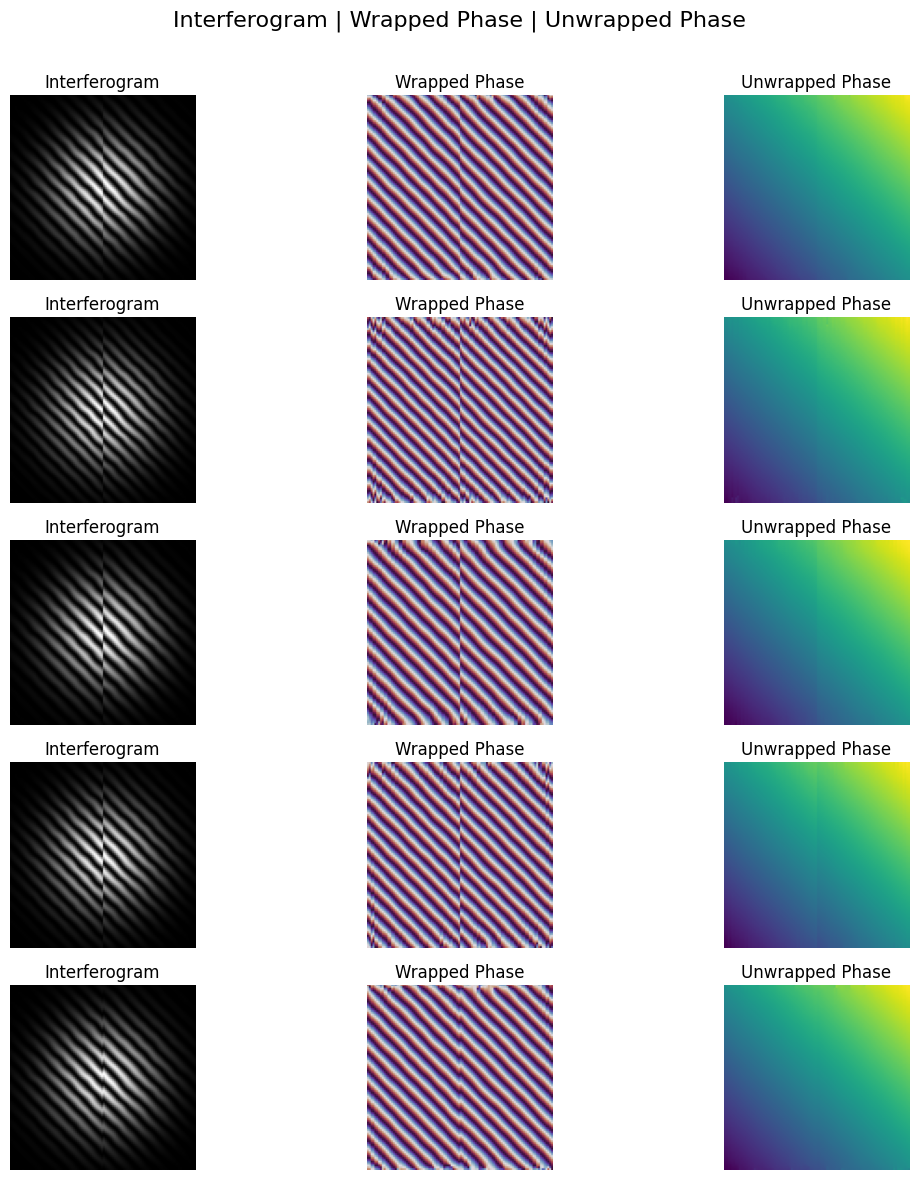

In [ ]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import random

# Path where you saved the dataset
root_path = "./Phase_Dataset_CLEAN"

interfero_path = os.path.join(root_path, "interferogram")
wrapped_path = os.path.join(root_path, "wrapped")
unwrapped_path = os.path.join(root_path, "unwrapped")

# Pick 5 random sample filenames
sample_files = sorted(os.listdir(wrapped_path))
sample_files = [f for f in sample_files if f.endswith(".mat")]
random_samples = random.sample(sample_files, 5)

# Plot
fig, axes = plt.subplots(len(random_samples), 3, figsize=(12, 12))
fig.suptitle("Interferogram | Wrapped Phase | Unwrapped Phase", fontsize=16)

for i, fname in enumerate(random_samples):
    # Load data
    wrapped = sio.loadmat(os.path.join(wrapped_path, fname))["wrapped"]
    unwrapped = sio.loadmat(os.path.join(unwrapped_path, fname))["unwrapped"]
    interfero = sio.loadmat(os.path.join(interfero_path, fname))["interferogram"]

    # Plot each
    axes[i, 0].imshow(interfero, cmap='gray')
    axes[i, 0].set_title("Interferogram")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(wrapped, cmap='twilight')
    axes[i, 1].set_title("Wrapped Phase")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(unwrapped, cmap='viridis')
    axes[i, 2].set_title("Unwrapped Phase")
    axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Dataset Loader

In [ ]:
import torch
from torch.utils.data import Dataset
import scipy.io as sio
import os
import numpy as np

class PhaseUnwrapDataset(Dataset):
    def __init__(self, input_dir, gt_dir, normalize=True):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.normalize = normalize

        self.input_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.mat')])
        self.gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.mat')])
        assert len(self.input_files) == len(self.gt_files), "Mismatch in input and GT files"

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_files[idx])

        # ✅ Load with correct keys
        input_data = sio.loadmat(input_path)['interferogram'].astype(np.float32)
        gt_phase   = sio.loadmat(gt_path)['unwrapped'].astype(np.float32)

        # ✅ Normalize if required
        if self.normalize:
            input_data = (input_data - np.min(input_data)) / np.ptp(input_data)
            gt_phase = (gt_phase - np.min(gt_phase)) / np.ptp(gt_phase)

        input_tensor = torch.from_numpy(input_data).unsqueeze(0)  # [1, H, W]
        gt_tensor = torch.from_numpy(gt_phase).unsqueeze(0)       # [1, H, W]

        return input_tensor, gt_tensor


In [ ]:
from torch.utils.data import random_split, DataLoader

# === Load the full dataset ===
full_dataset = PhaseUnwrapDataset(
    input_dir="/content/Phase_Dataset_CLEAN/interferogram",
    gt_dir="/content/Phase_Dataset_CLEAN/unwrapped"
)

# === Train/Validation Split ===
train_size = int(0.9 * len(full_dataset))  # 90% for training
val_size = len(full_dataset) - train_size  # 10% for validation

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# === DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath

# === Channel Attention ===
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# === Spatial Attention ===
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid() # same as equential layer with (nn.conv2d and nn.sigmoid) and do x*y in forward

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        y = self.conv(y)
        return x * self.sigmoid(y)

# === Transformer Block ===
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=4, mlp_ratio=4., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, dim)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x_ = x.flatten(2).transpose(1, 2)  # [B, H*W, C]
        x_ = self.norm1(x_)
        x_ = self.attn(x_, x_, x_)[0]
        x = x + self.drop_path(x_.transpose(1, 2).reshape(B, C, H, W))
        x_ = x.flatten(2).transpose(1, 2)
        x_ = self.norm2(x_)
        x_ = self.mlp(x_)
        x = x + self.drop_path(x_.transpose(1, 2).reshape(B, C, H, W))
        return x

# === Residual Block with Attention ===
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(out_channels)
        self.sa = SpatialAttention()

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.ca(x)
        x = self.sa(x)
        x += residual
        return self.relu(x)

# === Multi-Scale Fusion ===
class MultiScaleFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.down1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.conv = nn.Conv2d(3 * channels, channels, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)

        x1_up = self.up1(x2)
        x2_up = self.up2(x2)

        x1_up = F.interpolate(x1_up, size=x.shape[2:], mode='bilinear', align_corners=True)
        x2_up = F.interpolate(x2_up, size=x.shape[2:], mode='bilinear', align_corners=True)

        fused = torch.cat([x, x1_up, x2_up], dim=1)
        return self.conv(fused)

# === Final AdvancedUNet Model ===
class AdvancedUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super().__init__()
        f = init_features
        self.encoder1 = ResBlock(in_channels, f)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ResBlock(f, f*2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ResBlock(f*2, f*4)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            ResBlock(f*4, f*8),
            TransformerBlock(f*8),
            MultiScaleFusion(f*8)
        )

        self.up3 = nn.ConvTranspose2d(f*8, f*4, 2, 2)
        self.decoder3 = ResBlock(f*8, f*4)
        self.up2 = nn.ConvTranspose2d(f*4, f*2, 2, 2)
        self.decoder2 = ResBlock(f*4, f*2)
        self.up1 = nn.ConvTranspose2d(f*2, f, 2, 2)
        self.decoder1 = ResBlock(f*2, f)

        self.out = nn.Conv2d(f, out_channels, 1)

        self.phase_attention = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, in_channels, 3, padding=1),
            nn.Sigmoid()
        )

        self.skip1 = nn.Conv2d(f, f, 1)
        self.skip2 = nn.Conv2d(f*2, f*2, 1)
        self.skip3 = nn.Conv2d(f*4, f*4, 1)

    def forward(self, x):
      x = x * self.phase_attention(x)
      e1 = self.encoder1(x)
      e2 = self.encoder2(self.pool1(e1))
      e3 = self.encoder3(self.pool2(e2))

      # Bottleneck
      b = self.bottleneck(self.pool3(e3))

      # Decoder with upsampling and size alignment
      up_b = self.up3(b)
      if up_b.shape[-2:] != e3.shape[-2:]:
        up_b = F.interpolate(up_b, size=e3.shape[-2:], mode='bilinear', align_corners=True)
      d3 = self.decoder3(torch.cat([up_b, self.skip3(e3)], dim=1))

      up_d3 = self.up2(d3)
      if up_d3.shape[-2:] != e2.shape[-2:]:
        up_d3 = F.interpolate(up_d3, size=e2.shape[-2:], mode='bilinear', align_corners=True)
      d2 = self.decoder2(torch.cat([up_d3, self.skip2(e2)], dim=1))

      up_d2 = self.up1(d2)
      if up_d2.shape[-2:] != e1.shape[-2:]:
        up_d2 = F.interpolate(up_d2, size=e1.shape[-2:], mode='bilinear', align_corners=True)
      d1 = self.decoder1(torch.cat([up_d2, self.skip1(e1)], dim=1))

      # Output layer
      return self.out(d1)

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Traning

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Model Setup ===
model = AdvancedUNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.SmoothL1Loss()

# === Training Parameters ===
num_epochs = 100
best_val_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"[Epoch {epoch}] Training"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        preds = model(inputs)

        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch}: 🔧 Train Loss = {train_loss:.6f}")

    # === Validation Phase ===
    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)

            loss = loss_fn(preds, targets)
            val_loss += loss.item() * inputs.size(0)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    val_loss /= len(test_loader.dataset)

    # Flatten predictions and targets
    preds_flat = np.concatenate([p.reshape(-1) for p in all_preds])
    targets_flat = np.concatenate([t.reshape(-1) for t in all_targets])

    mae = mean_absolute_error(targets_flat, preds_flat)
    rmse = np.sqrt(mean_squared_error(targets_flat, preds_flat))

    print(f"           📊 Val Loss = {val_loss:.6f} | MAE = {mae:.4f} | RMSE = {rmse:.4f}")

    # === Save Best Model ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("           💾 Saved new best model!")


[Epoch 1] Training: 100%|██████████| 57/57 [00:07<00:00,  7.63it/s]


Epoch 1: 🔧 Train Loss = 0.031272
           📊 Val Loss = 0.029368 | MAE = 0.1984 | RMSE = 0.2424
           💾 Saved new best model!


[Epoch 2] Training: 100%|██████████| 57/57 [00:05<00:00, 11.04it/s]


Epoch 2: 🔧 Train Loss = 0.001274
           📊 Val Loss = 0.000946 | MAE = 0.0330 | RMSE = 0.0435
           💾 Saved new best model!


[Epoch 3] Training: 100%|██████████| 57/57 [00:05<00:00, 10.85it/s]


Epoch 3: 🔧 Train Loss = 0.000659
           📊 Val Loss = 0.000555 | MAE = 0.0244 | RMSE = 0.0333
           💾 Saved new best model!


[Epoch 4] Training: 100%|██████████| 57/57 [00:05<00:00, 11.02it/s]


Epoch 4: 🔧 Train Loss = 0.000469
           📊 Val Loss = 0.000418 | MAE = 0.0212 | RMSE = 0.0289
           💾 Saved new best model!


[Epoch 5] Training: 100%|██████████| 57/57 [00:05<00:00, 10.79it/s]


Epoch 5: 🔧 Train Loss = 0.000368
           📊 Val Loss = 0.000338 | MAE = 0.0191 | RMSE = 0.0260
           💾 Saved new best model!


[Epoch 6] Training: 100%|██████████| 57/57 [00:05<00:00, 10.89it/s]


Epoch 6: 🔧 Train Loss = 0.000304
           📊 Val Loss = 0.000286 | MAE = 0.0176 | RMSE = 0.0239
           💾 Saved new best model!


[Epoch 7] Training: 100%|██████████| 57/57 [00:05<00:00, 10.71it/s]


Epoch 7: 🔧 Train Loss = 0.000260
           📊 Val Loss = 0.000250 | MAE = 0.0164 | RMSE = 0.0224
           💾 Saved new best model!


[Epoch 8] Training: 100%|██████████| 57/57 [00:05<00:00, 10.79it/s]


Epoch 8: 🔧 Train Loss = 0.000229
           📊 Val Loss = 0.000224 | MAE = 0.0155 | RMSE = 0.0212
           💾 Saved new best model!


[Epoch 9] Training: 100%|██████████| 57/57 [00:05<00:00, 10.75it/s]


Epoch 9: 🔧 Train Loss = 0.000204
           📊 Val Loss = 0.000199 | MAE = 0.0146 | RMSE = 0.0199
           💾 Saved new best model!


[Epoch 10] Training: 100%|██████████| 57/57 [00:05<00:00, 10.77it/s]


Epoch 10: 🔧 Train Loss = 0.000184
           📊 Val Loss = 0.000187 | MAE = 0.0143 | RMSE = 0.0193
           💾 Saved new best model!


[Epoch 11] Training: 100%|██████████| 57/57 [00:05<00:00, 10.65it/s]


Epoch 11: 🔧 Train Loss = 0.000169
           📊 Val Loss = 0.000175 | MAE = 0.0141 | RMSE = 0.0187
           💾 Saved new best model!


[Epoch 12] Training: 100%|██████████| 57/57 [00:05<00:00, 10.61it/s]


Epoch 12: 🔧 Train Loss = 0.000157
           📊 Val Loss = 0.000161 | MAE = 0.0133 | RMSE = 0.0179
           💾 Saved new best model!


[Epoch 13] Training: 100%|██████████| 57/57 [00:05<00:00, 10.65it/s]


Epoch 13: 🔧 Train Loss = 0.000145
           📊 Val Loss = 0.000148 | MAE = 0.0127 | RMSE = 0.0172
           💾 Saved new best model!


[Epoch 14] Training: 100%|██████████| 57/57 [00:05<00:00, 10.47it/s]


Epoch 14: 🔧 Train Loss = 0.000134
           📊 Val Loss = 0.000139 | MAE = 0.0123 | RMSE = 0.0167
           💾 Saved new best model!


[Epoch 15] Training: 100%|██████████| 57/57 [00:05<00:00, 10.52it/s]


Epoch 15: 🔧 Train Loss = 0.000127
           📊 Val Loss = 0.000139 | MAE = 0.0124 | RMSE = 0.0167
           💾 Saved new best model!


[Epoch 16] Training: 100%|██████████| 57/57 [00:05<00:00, 10.42it/s]


Epoch 16: 🔧 Train Loss = 0.000119
           📊 Val Loss = 0.000134 | MAE = 0.0122 | RMSE = 0.0163
           💾 Saved new best model!


[Epoch 17] Training: 100%|██████████| 57/57 [00:05<00:00, 10.55it/s]


Epoch 17: 🔧 Train Loss = 0.000114
           📊 Val Loss = 0.000120 | MAE = 0.0114 | RMSE = 0.0155
           💾 Saved new best model!


[Epoch 18] Training: 100%|██████████| 57/57 [00:06<00:00,  8.35it/s]


Epoch 18: 🔧 Train Loss = 0.000105
           📊 Val Loss = 0.000122 | MAE = 0.0116 | RMSE = 0.0156


[Epoch 19] Training: 100%|██████████| 57/57 [00:05<00:00, 10.63it/s]


Epoch 19: 🔧 Train Loss = 0.000102
           📊 Val Loss = 0.000109 | MAE = 0.0109 | RMSE = 0.0148
           💾 Saved new best model!


[Epoch 20] Training: 100%|██████████| 57/57 [00:05<00:00, 10.50it/s]


Epoch 20: 🔧 Train Loss = 0.000097
           📊 Val Loss = 0.000108 | MAE = 0.0108 | RMSE = 0.0147
           💾 Saved new best model!


[Epoch 21] Training: 100%|██████████| 57/57 [00:05<00:00, 10.68it/s]


Epoch 21: 🔧 Train Loss = 0.000093
           📊 Val Loss = 0.000104 | MAE = 0.0107 | RMSE = 0.0144
           💾 Saved new best model!


[Epoch 22] Training: 100%|██████████| 57/57 [00:06<00:00,  8.71it/s]


Epoch 22: 🔧 Train Loss = 0.000089
           📊 Val Loss = 0.000098 | MAE = 0.0103 | RMSE = 0.0140
           💾 Saved new best model!


[Epoch 23] Training: 100%|██████████| 57/57 [00:05<00:00,  9.95it/s]


Epoch 23: 🔧 Train Loss = 0.000084
           📊 Val Loss = 0.000097 | MAE = 0.0104 | RMSE = 0.0139
           💾 Saved new best model!


[Epoch 24] Training: 100%|██████████| 57/57 [00:05<00:00, 10.56it/s]


Epoch 24: 🔧 Train Loss = 0.000082
           📊 Val Loss = 0.000093 | MAE = 0.0101 | RMSE = 0.0137
           💾 Saved new best model!


[Epoch 25] Training: 100%|██████████| 57/57 [00:05<00:00, 10.67it/s]


Epoch 25: 🔧 Train Loss = 0.000078
           📊 Val Loss = 0.000093 | MAE = 0.0104 | RMSE = 0.0137
           💾 Saved new best model!


[Epoch 26] Training: 100%|██████████| 57/57 [00:05<00:00, 10.50it/s]


Epoch 26: 🔧 Train Loss = 0.000078
           📊 Val Loss = 0.000094 | MAE = 0.0102 | RMSE = 0.0137


[Epoch 27] Training: 100%|██████████| 57/57 [00:05<00:00, 10.63it/s]


Epoch 27: 🔧 Train Loss = 0.000074
           📊 Val Loss = 0.000094 | MAE = 0.0104 | RMSE = 0.0137


[Epoch 28] Training: 100%|██████████| 57/57 [00:05<00:00, 10.47it/s]


Epoch 28: 🔧 Train Loss = 0.000070
           📊 Val Loss = 0.000087 | MAE = 0.0100 | RMSE = 0.0132
           💾 Saved new best model!


[Epoch 29] Training: 100%|██████████| 57/57 [00:05<00:00, 10.60it/s]


Epoch 29: 🔧 Train Loss = 0.000068
           📊 Val Loss = 0.000090 | MAE = 0.0101 | RMSE = 0.0134


[Epoch 30] Training: 100%|██████████| 57/57 [00:05<00:00,  9.96it/s]


Epoch 30: 🔧 Train Loss = 0.000066
           📊 Val Loss = 0.000089 | MAE = 0.0100 | RMSE = 0.0133


[Epoch 31] Training: 100%|██████████| 57/57 [00:05<00:00, 10.61it/s]


Epoch 31: 🔧 Train Loss = 0.000063
           📊 Val Loss = 0.000084 | MAE = 0.0097 | RMSE = 0.0129
           💾 Saved new best model!


[Epoch 32] Training: 100%|██████████| 57/57 [00:05<00:00, 10.52it/s]


Epoch 32: 🔧 Train Loss = 0.000061
           📊 Val Loss = 0.000099 | MAE = 0.0106 | RMSE = 0.0141


[Epoch 33] Training: 100%|██████████| 57/57 [00:05<00:00, 10.57it/s]


Epoch 33: 🔧 Train Loss = 0.000061
           📊 Val Loss = 0.000093 | MAE = 0.0107 | RMSE = 0.0137


[Epoch 34] Training: 100%|██████████| 57/57 [00:05<00:00, 10.59it/s]


Epoch 34: 🔧 Train Loss = 0.000057
           📊 Val Loss = 0.000077 | MAE = 0.0093 | RMSE = 0.0124
           💾 Saved new best model!


[Epoch 35] Training: 100%|██████████| 57/57 [00:05<00:00, 10.55it/s]


Epoch 35: 🔧 Train Loss = 0.000056
           📊 Val Loss = 0.000084 | MAE = 0.0100 | RMSE = 0.0130


[Epoch 36] Training: 100%|██████████| 57/57 [00:05<00:00, 10.64it/s]


Epoch 36: 🔧 Train Loss = 0.000058
           📊 Val Loss = 0.000077 | MAE = 0.0091 | RMSE = 0.0124
           💾 Saved new best model!


[Epoch 37] Training: 100%|██████████| 57/57 [00:05<00:00, 10.42it/s]


Epoch 37: 🔧 Train Loss = 0.000055
           📊 Val Loss = 0.000080 | MAE = 0.0096 | RMSE = 0.0127


[Epoch 38] Training: 100%|██████████| 57/57 [00:06<00:00,  9.41it/s]


Epoch 38: 🔧 Train Loss = 0.000053
           📊 Val Loss = 0.000079 | MAE = 0.0094 | RMSE = 0.0125


[Epoch 39] Training: 100%|██████████| 57/57 [00:05<00:00,  9.91it/s]


Epoch 39: 🔧 Train Loss = 0.000052
           📊 Val Loss = 0.000083 | MAE = 0.0100 | RMSE = 0.0129


[Epoch 40] Training: 100%|██████████| 57/57 [00:05<00:00,  9.92it/s]


Epoch 40: 🔧 Train Loss = 0.000050
           📊 Val Loss = 0.000075 | MAE = 0.0094 | RMSE = 0.0123
           💾 Saved new best model!


[Epoch 41] Training: 100%|██████████| 57/57 [00:05<00:00, 10.51it/s]


Epoch 41: 🔧 Train Loss = 0.000046
           📊 Val Loss = 0.000068 | MAE = 0.0085 | RMSE = 0.0116
           💾 Saved new best model!


[Epoch 42] Training: 100%|██████████| 57/57 [00:05<00:00, 10.58it/s]


Epoch 42: 🔧 Train Loss = 0.000046
           📊 Val Loss = 0.000081 | MAE = 0.0097 | RMSE = 0.0127


[Epoch 43] Training: 100%|██████████| 57/57 [00:05<00:00, 10.50it/s]


Epoch 43: 🔧 Train Loss = 0.000044
           📊 Val Loss = 0.000074 | MAE = 0.0090 | RMSE = 0.0122


[Epoch 44] Training: 100%|██████████| 57/57 [00:05<00:00, 10.61it/s]


Epoch 44: 🔧 Train Loss = 0.000044
           📊 Val Loss = 0.000093 | MAE = 0.0105 | RMSE = 0.0137


[Epoch 45] Training: 100%|██████████| 57/57 [00:05<00:00, 10.51it/s]


Epoch 45: 🔧 Train Loss = 0.000043
           📊 Val Loss = 0.000067 | MAE = 0.0086 | RMSE = 0.0116
           💾 Saved new best model!


[Epoch 46] Training: 100%|██████████| 57/57 [00:05<00:00, 10.61it/s]


Epoch 46: 🔧 Train Loss = 0.000043
           📊 Val Loss = 0.000065 | MAE = 0.0085 | RMSE = 0.0114
           💾 Saved new best model!


[Epoch 47] Training: 100%|██████████| 57/57 [00:05<00:00, 10.51it/s]


Epoch 47: 🔧 Train Loss = 0.000040
           📊 Val Loss = 0.000068 | MAE = 0.0088 | RMSE = 0.0117


[Epoch 48] Training: 100%|██████████| 57/57 [00:05<00:00, 10.61it/s]


Epoch 48: 🔧 Train Loss = 0.000041
           📊 Val Loss = 0.000074 | MAE = 0.0093 | RMSE = 0.0121


[Epoch 49] Training: 100%|██████████| 57/57 [00:05<00:00, 10.50it/s]


Epoch 49: 🔧 Train Loss = 0.000041
           📊 Val Loss = 0.000071 | MAE = 0.0090 | RMSE = 0.0119


[Epoch 50] Training: 100%|██████████| 57/57 [00:05<00:00, 10.63it/s]


Epoch 50: 🔧 Train Loss = 0.000040
           📊 Val Loss = 0.000073 | MAE = 0.0091 | RMSE = 0.0121


[Epoch 51] Training: 100%|██████████| 57/57 [00:05<00:00, 10.50it/s]


Epoch 51: 🔧 Train Loss = 0.000038
           📊 Val Loss = 0.000071 | MAE = 0.0090 | RMSE = 0.0119


[Epoch 52] Training: 100%|██████████| 57/57 [00:05<00:00, 10.65it/s]


Epoch 52: 🔧 Train Loss = 0.000037
           📊 Val Loss = 0.000062 | MAE = 0.0082 | RMSE = 0.0111
           💾 Saved new best model!


[Epoch 53] Training: 100%|██████████| 57/57 [00:05<00:00, 10.58it/s]


Epoch 53: 🔧 Train Loss = 0.000037
           📊 Val Loss = 0.000072 | MAE = 0.0090 | RMSE = 0.0120


[Epoch 54] Training: 100%|██████████| 57/57 [00:05<00:00, 10.51it/s]


Epoch 54: 🔧 Train Loss = 0.000035
           📊 Val Loss = 0.000060 | MAE = 0.0081 | RMSE = 0.0110
           💾 Saved new best model!


[Epoch 55] Training: 100%|██████████| 57/57 [00:05<00:00, 10.59it/s]


Epoch 55: 🔧 Train Loss = 0.000034
           📊 Val Loss = 0.000062 | MAE = 0.0083 | RMSE = 0.0111


[Epoch 56] Training: 100%|██████████| 57/57 [00:05<00:00, 10.53it/s]


Epoch 56: 🔧 Train Loss = 0.000033
           📊 Val Loss = 0.000060 | MAE = 0.0081 | RMSE = 0.0110


[Epoch 57] Training: 100%|██████████| 57/57 [00:05<00:00, 10.61it/s]


Epoch 57: 🔧 Train Loss = 0.000034
           📊 Val Loss = 0.000059 | MAE = 0.0080 | RMSE = 0.0108
           💾 Saved new best model!


[Epoch 58] Training: 100%|██████████| 57/57 [00:05<00:00, 10.49it/s]


Epoch 58: 🔧 Train Loss = 0.000032
           📊 Val Loss = 0.000075 | MAE = 0.0093 | RMSE = 0.0122


[Epoch 59] Training: 100%|██████████| 57/57 [00:05<00:00, 10.63it/s]


Epoch 59: 🔧 Train Loss = 0.000033
           📊 Val Loss = 0.000059 | MAE = 0.0081 | RMSE = 0.0109


[Epoch 60] Training: 100%|██████████| 57/57 [00:05<00:00, 10.48it/s]


Epoch 60: 🔧 Train Loss = 0.000031
           📊 Val Loss = 0.000060 | MAE = 0.0080 | RMSE = 0.0109


[Epoch 61] Training: 100%|██████████| 57/57 [00:05<00:00, 10.58it/s]


Epoch 61: 🔧 Train Loss = 0.000030
           📊 Val Loss = 0.000059 | MAE = 0.0080 | RMSE = 0.0109


[Epoch 62] Training: 100%|██████████| 57/57 [00:05<00:00, 10.46it/s]


Epoch 62: 🔧 Train Loss = 0.000031
           📊 Val Loss = 0.000060 | MAE = 0.0082 | RMSE = 0.0110


[Epoch 63] Training: 100%|██████████| 57/57 [00:05<00:00, 10.60it/s]


Epoch 63: 🔧 Train Loss = 0.000031
           📊 Val Loss = 0.000063 | MAE = 0.0084 | RMSE = 0.0112


[Epoch 64] Training: 100%|██████████| 57/57 [00:05<00:00, 10.42it/s]


Epoch 64: 🔧 Train Loss = 0.000029
           📊 Val Loss = 0.000057 | MAE = 0.0078 | RMSE = 0.0107
           💾 Saved new best model!


[Epoch 65] Training: 100%|██████████| 57/57 [00:05<00:00, 10.60it/s]


Epoch 65: 🔧 Train Loss = 0.000029
           📊 Val Loss = 0.000059 | MAE = 0.0079 | RMSE = 0.0109


[Epoch 66] Training: 100%|██████████| 57/57 [00:05<00:00, 10.48it/s]


Epoch 66: 🔧 Train Loss = 0.000030
           📊 Val Loss = 0.000094 | MAE = 0.0105 | RMSE = 0.0137


[Epoch 67] Training: 100%|██████████| 57/57 [00:05<00:00, 10.60it/s]


Epoch 67: 🔧 Train Loss = 0.000030
           📊 Val Loss = 0.000063 | MAE = 0.0084 | RMSE = 0.0112


[Epoch 68] Training: 100%|██████████| 57/57 [00:05<00:00, 10.47it/s]


Epoch 68: 🔧 Train Loss = 0.000027
           📊 Val Loss = 0.000059 | MAE = 0.0080 | RMSE = 0.0109


[Epoch 69] Training: 100%|██████████| 57/57 [00:05<00:00, 10.59it/s]


Epoch 69: 🔧 Train Loss = 0.000028
           📊 Val Loss = 0.000054 | MAE = 0.0076 | RMSE = 0.0104
           💾 Saved new best model!


[Epoch 70] Training: 100%|██████████| 57/57 [00:05<00:00, 10.53it/s]


Epoch 70: 🔧 Train Loss = 0.000027
           📊 Val Loss = 0.000056 | MAE = 0.0078 | RMSE = 0.0106


[Epoch 71] Training: 100%|██████████| 57/57 [00:05<00:00, 10.55it/s]


Epoch 71: 🔧 Train Loss = 0.000026
           📊 Val Loss = 0.000065 | MAE = 0.0084 | RMSE = 0.0114


[Epoch 72] Training: 100%|██████████| 57/57 [00:05<00:00, 10.56it/s]


Epoch 72: 🔧 Train Loss = 0.000026
           📊 Val Loss = 0.000060 | MAE = 0.0081 | RMSE = 0.0109


[Epoch 73] Training: 100%|██████████| 57/57 [00:05<00:00, 10.49it/s]


Epoch 73: 🔧 Train Loss = 0.000025
           📊 Val Loss = 0.000063 | MAE = 0.0085 | RMSE = 0.0112


[Epoch 74] Training: 100%|██████████| 57/57 [00:05<00:00, 10.57it/s]


Epoch 74: 🔧 Train Loss = 0.000026
           📊 Val Loss = 0.000053 | MAE = 0.0075 | RMSE = 0.0103
           💾 Saved new best model!


[Epoch 75] Training: 100%|██████████| 57/57 [00:05<00:00, 10.46it/s]


Epoch 75: 🔧 Train Loss = 0.000026
           📊 Val Loss = 0.000058 | MAE = 0.0080 | RMSE = 0.0108


[Epoch 76] Training: 100%|██████████| 57/57 [00:05<00:00, 10.60it/s]


Epoch 76: 🔧 Train Loss = 0.000025
           📊 Val Loss = 0.000054 | MAE = 0.0077 | RMSE = 0.0104


[Epoch 77] Training: 100%|██████████| 57/57 [00:05<00:00, 10.41it/s]


Epoch 77: 🔧 Train Loss = 0.000023
           📊 Val Loss = 0.000060 | MAE = 0.0081 | RMSE = 0.0109


[Epoch 78] Training: 100%|██████████| 57/57 [00:05<00:00, 10.59it/s]


Epoch 78: 🔧 Train Loss = 0.000024
           📊 Val Loss = 0.000049 | MAE = 0.0073 | RMSE = 0.0099
           💾 Saved new best model!


[Epoch 79] Training: 100%|██████████| 57/57 [00:05<00:00, 10.51it/s]


Epoch 79: 🔧 Train Loss = 0.000026
           📊 Val Loss = 0.000057 | MAE = 0.0078 | RMSE = 0.0107


[Epoch 80] Training: 100%|██████████| 57/57 [00:05<00:00, 10.62it/s]


Epoch 80: 🔧 Train Loss = 0.000024
           📊 Val Loss = 0.000057 | MAE = 0.0079 | RMSE = 0.0107


[Epoch 81] Training: 100%|██████████| 57/57 [00:05<00:00, 10.46it/s]


Epoch 81: 🔧 Train Loss = 0.000025
           📊 Val Loss = 0.000053 | MAE = 0.0074 | RMSE = 0.0102


[Epoch 82] Training: 100%|██████████| 57/57 [00:05<00:00, 10.61it/s]


Epoch 82: 🔧 Train Loss = 0.000023
           📊 Val Loss = 0.000054 | MAE = 0.0076 | RMSE = 0.0104


[Epoch 83] Training: 100%|██████████| 57/57 [00:05<00:00, 10.47it/s]


Epoch 83: 🔧 Train Loss = 0.000026
           📊 Val Loss = 0.000054 | MAE = 0.0076 | RMSE = 0.0104


[Epoch 84] Training: 100%|██████████| 57/57 [00:05<00:00, 10.59it/s]


Epoch 84: 🔧 Train Loss = 0.000023
           📊 Val Loss = 0.000057 | MAE = 0.0078 | RMSE = 0.0107


[Epoch 85] Training: 100%|██████████| 57/57 [00:05<00:00, 10.51it/s]


Epoch 85: 🔧 Train Loss = 0.000021
           📊 Val Loss = 0.000061 | MAE = 0.0082 | RMSE = 0.0111


[Epoch 86] Training: 100%|██████████| 57/57 [00:05<00:00, 10.60it/s]


Epoch 86: 🔧 Train Loss = 0.000022
           📊 Val Loss = 0.000057 | MAE = 0.0079 | RMSE = 0.0107


[Epoch 87] Training: 100%|██████████| 57/57 [00:05<00:00, 10.55it/s]


Epoch 87: 🔧 Train Loss = 0.000022
           📊 Val Loss = 0.000059 | MAE = 0.0080 | RMSE = 0.0109


[Epoch 88] Training: 100%|██████████| 57/57 [00:05<00:00, 10.55it/s]


Epoch 88: 🔧 Train Loss = 0.000023
           📊 Val Loss = 0.000052 | MAE = 0.0073 | RMSE = 0.0102


[Epoch 89] Training: 100%|██████████| 57/57 [00:05<00:00, 10.58it/s]


Epoch 89: 🔧 Train Loss = 0.000024
           📊 Val Loss = 0.000064 | MAE = 0.0085 | RMSE = 0.0113


[Epoch 90] Training: 100%|██████████| 57/57 [00:05<00:00, 10.51it/s]


Epoch 90: 🔧 Train Loss = 0.000020
           📊 Val Loss = 0.000053 | MAE = 0.0076 | RMSE = 0.0103


[Epoch 91] Training: 100%|██████████| 57/57 [00:05<00:00, 10.62it/s]


Epoch 91: 🔧 Train Loss = 0.000021
           📊 Val Loss = 0.000049 | MAE = 0.0071 | RMSE = 0.0099


[Epoch 92] Training: 100%|██████████| 57/57 [00:05<00:00, 10.47it/s]


Epoch 92: 🔧 Train Loss = 0.000021
           📊 Val Loss = 0.000062 | MAE = 0.0082 | RMSE = 0.0111


[Epoch 93] Training: 100%|██████████| 57/57 [00:05<00:00, 10.61it/s]


Epoch 93: 🔧 Train Loss = 0.000021
           📊 Val Loss = 0.000059 | MAE = 0.0078 | RMSE = 0.0108


[Epoch 94] Training: 100%|██████████| 57/57 [00:05<00:00, 10.41it/s]


Epoch 94: 🔧 Train Loss = 0.000021
           📊 Val Loss = 0.000055 | MAE = 0.0077 | RMSE = 0.0105


[Epoch 95] Training: 100%|██████████| 57/57 [00:05<00:00, 10.59it/s]


Epoch 95: 🔧 Train Loss = 0.000020
           📊 Val Loss = 0.000049 | MAE = 0.0071 | RMSE = 0.0099
           💾 Saved new best model!


[Epoch 96] Training: 100%|██████████| 57/57 [00:05<00:00, 10.47it/s]


Epoch 96: 🔧 Train Loss = 0.000020
           📊 Val Loss = 0.000051 | MAE = 0.0073 | RMSE = 0.0101


[Epoch 97] Training: 100%|██████████| 57/57 [00:05<00:00, 10.48it/s]


Epoch 97: 🔧 Train Loss = 0.000019
           📊 Val Loss = 0.000049 | MAE = 0.0071 | RMSE = 0.0099


[Epoch 98] Training: 100%|██████████| 57/57 [00:05<00:00, 10.20it/s]


Epoch 98: 🔧 Train Loss = 0.000019
           📊 Val Loss = 0.000056 | MAE = 0.0079 | RMSE = 0.0106


[Epoch 99] Training: 100%|██████████| 57/57 [00:05<00:00, 10.51it/s]


Epoch 99: 🔧 Train Loss = 0.000020
           📊 Val Loss = 0.000059 | MAE = 0.0079 | RMSE = 0.0108


[Epoch 100] Training: 100%|██████████| 57/57 [00:05<00:00, 10.07it/s]


Epoch 100: 🔧 Train Loss = 0.000022
           📊 Val Loss = 0.000057 | MAE = 0.0078 | RMSE = 0.0106


Testing and Visualisation

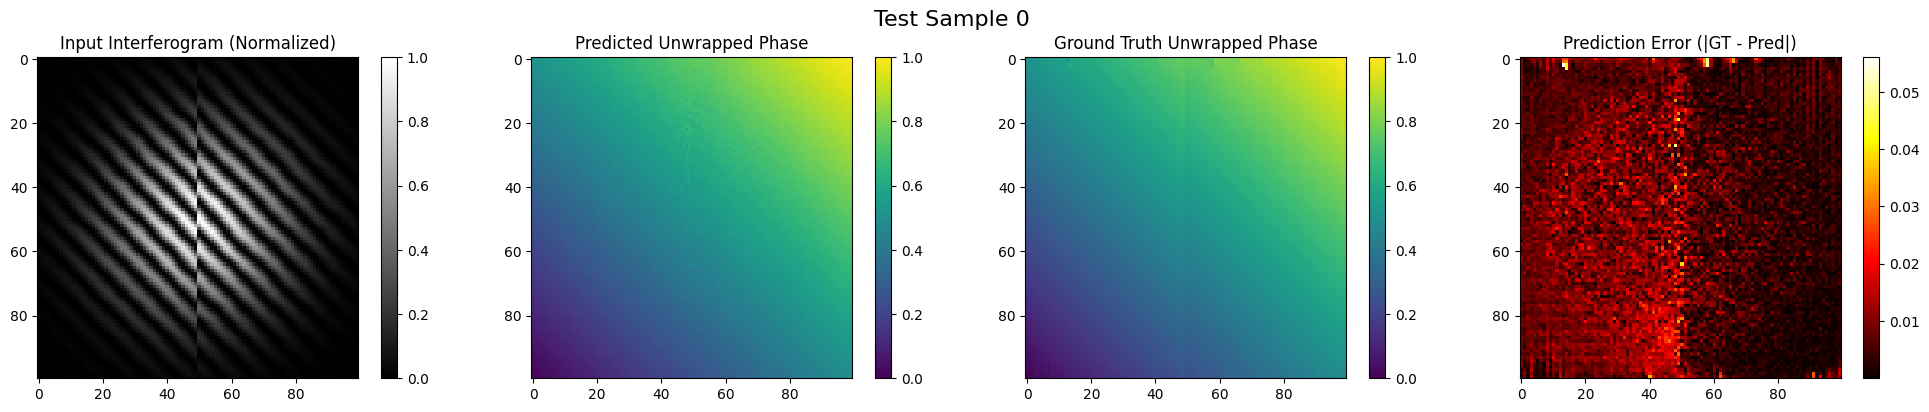

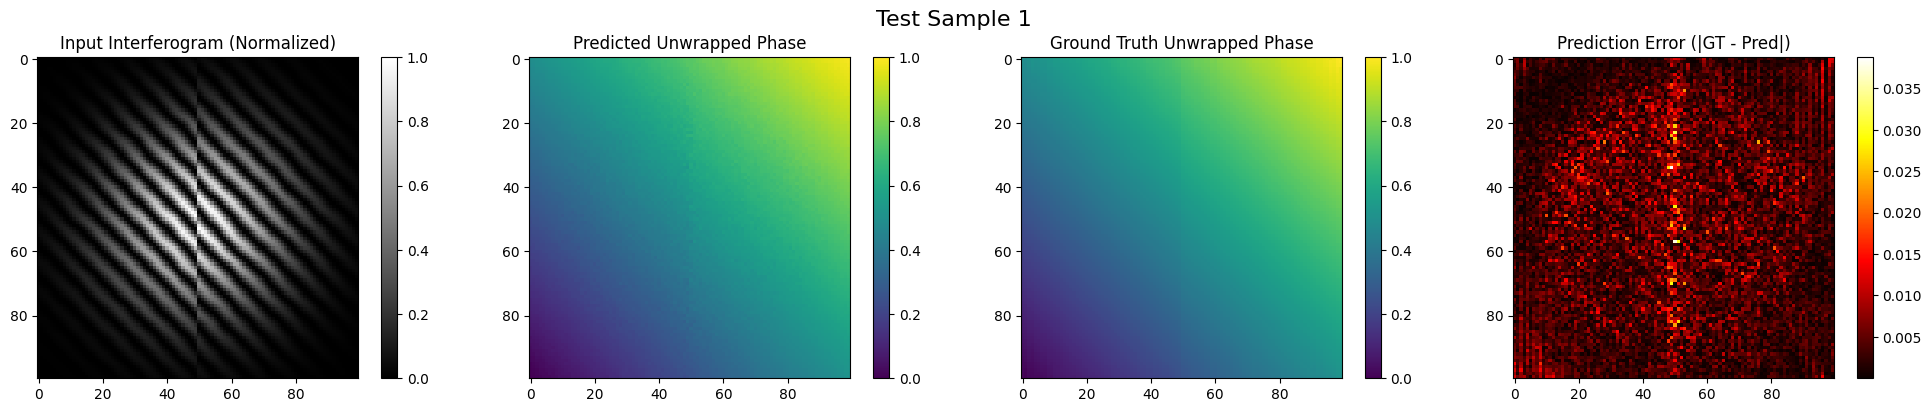

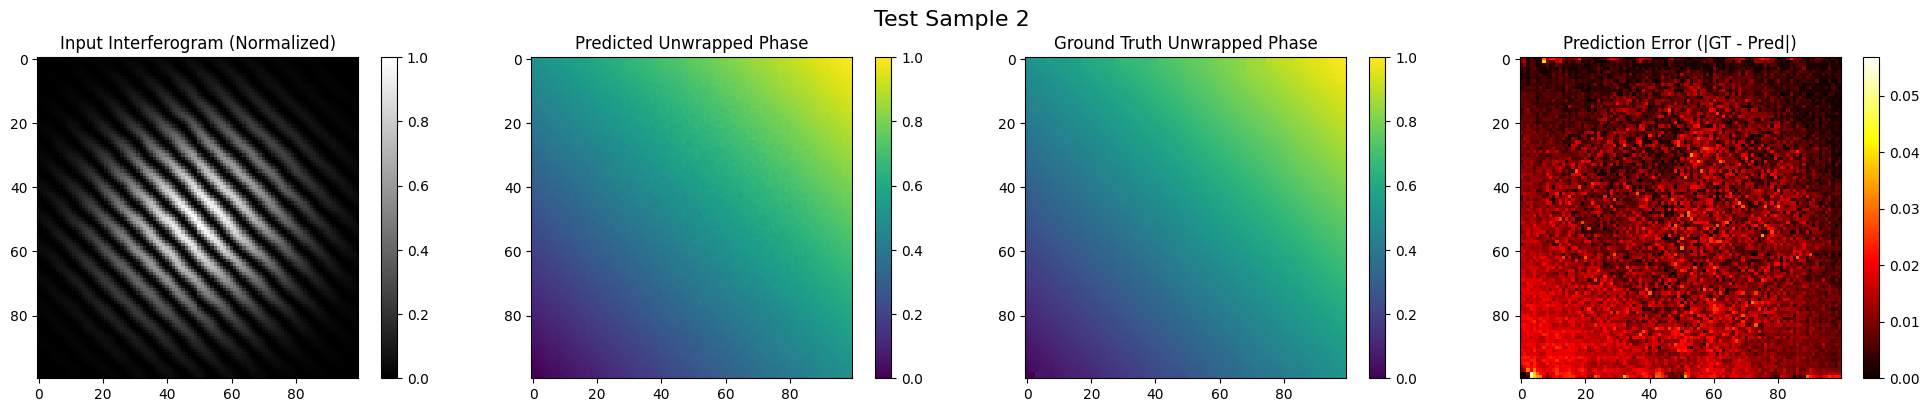

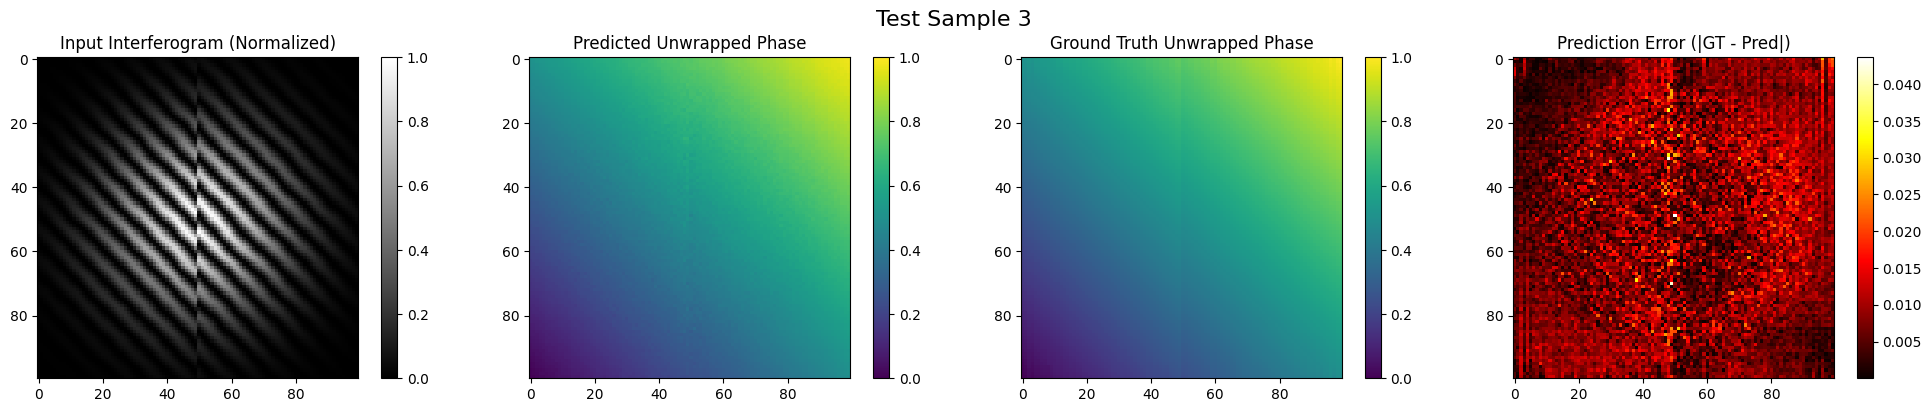

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# === Load model ===
model = AdvancedUNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# === Load one batch from test set ===
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)

# === Predict ===
with torch.no_grad():
    preds = model(inputs).cpu().numpy()

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()

# === Show first 4 samples in batch ===
num_samples = min(4, inputs.shape[0])
for i in range(num_samples):
    inp_img = inputs[i, 0]  # ⚠️ Removed `* np.pi` scaling
    pred_img = preds[i, 0]
    gt_img = targets[i, 0]

    vmin = np.min(gt_img)
    vmax = np.max(gt_img)

    plt.figure(figsize=(20, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(inp_img, cmap='gray')
    plt.title("Input Interferogram (Normalized)")
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.imshow(pred_img, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title("Predicted Unwrapped Phase")
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.imshow(gt_img, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title("Ground Truth Unwrapped Phase")
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.imshow(np.abs(gt_img - pred_img), cmap='hot')
    plt.title("Prediction Error (|GT - Pred|)")
    plt.colorbar()

    plt.suptitle(f"Test Sample {i}", fontsize=16)
    plt.tight_layout()
    plt.show()
